Homework 3- Implementation of my own convolutional using Pytorch
===

## Imports


In [203]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall


## Import Fasion MNIST and Batch Segmentation

In [204]:
# Definir transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar el conjunto de datos MNIST fashion
train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, transform=transform)

#MNIST numeros
#train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
#test_dataset = datasets.MNIST('data', train=False, transform=transform)



# Definir el tamaño del lote y crear los iteradores de datos
batch_size = 192
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

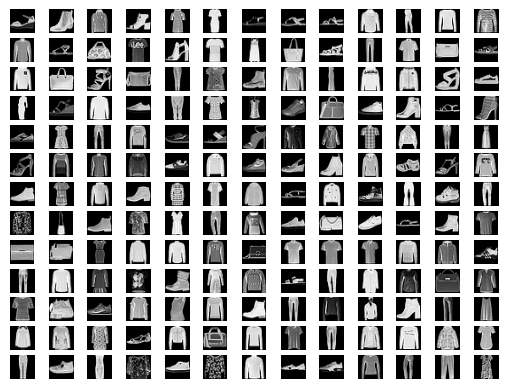

In [205]:
#show 10 images from the dataset
import matplotlib.pyplot as plt
import numpy as np

def show_images(images):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='gray')
        ax.axis('off')

for x, y in train_loader:
    show_images(x)
    break

## Verify if is cuda available

In [206]:
# Verificar si hay una GPU disponible y establecer el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Pytorch pre-build class for Convolution (Example implementation) 

In [207]:
'''
class MyConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConvolution, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = nn.Parameter(torch.zeros(out_channels)).to(device)
        self.kernel_size = kernel_size

    def forward(self, x):
        output = F.conv2d(x, self.weight, bias=self.bias, stride=1, padding=0)
        return output
'''

'\nclass MyConvolution(nn.Module):\n    def __init__(self, in_channels, out_channels, kernel_size):\n        super(MyConvolution, self).__init__()\n        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)\n        self.bias = nn.Parameter(torch.zeros(out_channels)).to(device)\n        self.kernel_size = kernel_size\n\n    def forward(self, x):\n        output = F.conv2d(x, self.weight, bias=self.bias, stride=1, padding=0)\n        return output\n'

## Own convolucional class

In [208]:
#this is my first intent to create a convolutional layer, it works but is too slow because I use a for loop. Then i try to optimize it using tensor unfold and matrix multiplication
'''
class MyConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConvolution, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = nn.Parameter(torch.zeros(out_channels)).to(device)
        self.kernel_size = kernel_size

    def forward(self, x):
        batch_size, in_channels, height, width = x.size()
        out_channels = self.weight.size(0)

        output_height = height - self.kernel_size + 1
        output_width = width - self.kernel_size + 1

        output = torch.zeros(batch_size, out_channels, output_height, output_width).to(device)

        # Realizar la convolución
        for i in range(output_height):
            for j in range(output_width):
                receptive_field = x[:, :, i:i+self.kernel_size, j:j+self.kernel_size].to(device)
                conv = torch.sum(receptive_field.unsqueeze(1) * self.weight.unsqueeze(0), dim=(2, 3, 4)) + self.bias.unsqueeze(0)
                output[:, :, i, j] = conv.squeeze()

        return output
'''

'\nclass MyConvolution(nn.Module):\n    def __init__(self, in_channels, out_channels, kernel_size):\n        super(MyConvolution, self).__init__()\n        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)\n        self.bias = nn.Parameter(torch.zeros(out_channels)).to(device)\n        self.kernel_size = kernel_size\n\n    def forward(self, x):\n        batch_size, in_channels, height, width = x.size()\n        out_channels = self.weight.size(0)\n\n        output_height = height - self.kernel_size + 1\n        output_width = width - self.kernel_size + 1\n\n        output = torch.zeros(batch_size, out_channels, output_height, output_width).to(device)\n\n        # Realizar la convolución\n        for i in range(output_height):\n            for j in range(output_width):\n                receptive_field = x[:, :, i:i+self.kernel_size, j:j+self.kernel_size].to(device)\n                conv = torch.sum(receptive_field.unsqueeze(1) * self.

In [209]:
# Definir la clase de convolución personalizada
class MyConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConvolution, self).__init__()
        #Initialize weights with shape (how many filters, how many channels (ex. RGB=3), kernel size , kernel size) using random values
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = nn.Parameter(torch.zeros(out_channels)).to(device)
        self.kernel_size = kernel_size

    def forward(self, x):
        #get the shape of the input
        batch_size, in_channels, height, width = x.size()
        #get the shape of the output, that is, the number of filters
        out_channels = self.weight.size(0)
        #compute the output height and width of the output image after the convolution (this equation only works for stride=1 and padding=0)
        output_height = height - self.kernel_size + 1
        output_width = width - self.kernel_size + 1

        #unfold the input image to get the patches, that is, the input image is divided into patches of size kernel_size x kernel_size
        x_unfolded = F.unfold(x, self.kernel_size)  #after unfolding, the shape of x_unfolded is (batch_size, in_channels * kernel_size * kernel_size, output_height * output_width)
        #a reshape is performed to get the shape (batch_size, in_channels, kernel_size * kernel_size, output_height * output_width)
        x_unfolded = x_unfolded.view(batch_size, in_channels* self.kernel_size *self.kernel_size , output_height * output_width) 
        #change the order of the dimensions to get the shape (batch_size, output_height * output_width, in_channels * kernel_size * kernel_size)
        x_unfolded=x_unfolded.permute(0, 2, 1)
        #reshape to perform the matrix multiplication, Note: we can not perform this reshape after the unfolding, the order of reshape the dimensions is important
        x_unfolded=x_unfolded.view(batch_size, output_height * output_width, in_channels*self.kernel_size *self.kernel_size) 

        
        #flatten the weights to get the shape (out_channels, in_channels * kernel_size * kernel_size), this is done so that when matrix multiplication is performed,
        #the weights of each filter are multiplied by the corresponding patches of the input image. Is like a dot product between the weights of each filter and the patches of the input image
        #The elemet wise and the sum is implicit in the matrix multiplication using this flatten weights
        weight_view = self.weight.view(out_channels, -1)    #the -1 is used to infer the size of the second dimension, that is, the number of elements of the second dimension is calculated automatically

        #perform the matrix multiplication between the patches of the input image and the weights of each filter
        conv = torch.matmul(x_unfolded, weight_view.t())
        #change the order of the dimensions to get the shape (batch_size, out_channels, output_height * output_width)
        conv =conv.permute(0, 2, 1)
        conv=conv.contiguous()  #is used to renew the memory allocation of the tensor and its mapping, for some reazon this is necessary to use the view method (use this when you get contiguous errors)
        
        conv = conv.view(batch_size, out_channels, output_height, output_width) 
        #add the bias to the output of the convolution, is necesary to reshape the bias to get the shape (1, out_channels, 1, 1) to perform the sum.
        #when we have a dimension of size 1, we expand the tensor to in this dimension to have the same size as the other dimensions (conocido como transmision del tamaño 1 a lo largo de los ejes o broadcasting)
        #is like duplicate the tensor in the dimensions of size 1, in this way we can perform the sum for example between a tensor of size (1, 3, 1, 1) and a tensor of size (64, 3, 26, 26)
        conv = conv + self.bias.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        

        return conv




## Neural Network class

In [210]:
# Define the neural network
class Net(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Net, self).__init__()
        self.out_channels = out_channels
        #we will use 2 convolutional layers, both with kernel size 3 and stride 1 
        self.conv1 = MyConvolution(in_channels, out_channels, kernel_size) #para gray scale images y 3 filtros, in_channels=1, out_channels=3
        self.conv2 = MyConvolution(out_channels, out_channels*out_channels, kernel_size)    #el input son el numero de filtros de la capa anterior, en este caso 3, el output son 3imagenes con *3 filtros cada una=9 filtros

        #at the end of the second maxpooling the image size of the 9images is 5x5, the 128 is the number you want to get in the output of the fully connected layer
        self.fc1 = nn.Linear(out_channels*out_channels * 5 * 5, 128)
        #the output of the fully connected layer is 10, because we have 10 classes
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #flatten the output of the second convolutional layer to perform the matrix multiplication with the fully connected layer
        x = x.view(-1, self.out_channels*self.out_channels * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [211]:

def trainig(train_loader,in_channels,filtros,kernel_size,epochs,lr):
    # Create the network, define the criterion and optimizer
    seed = 1
    torch.manual_seed(seed)
    model = Net(in_channels,filtros, kernel_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # train the network
    epochs = epochs
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # forward and loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward and optimize
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}')
                last_running_loss_toSafe = running_loss
                running_loss = 0.0
                
        losses.append(last_running_loss_toSafe / 100)
    return model,losses


In [212]:
def testing(model,test_loader):
    # Evaluación del modelo
    correct = 0
    total = 0
    accuracy = Accuracy(task="multiclass", num_classes=10)

    #inicalizamos listas para metricas
    accuracy = Accuracy(num_classes=10,average='macro',task='multiclass') 
    precision = Precision(num_classes=10, average='macro',task='multiclass') 
    recall = Recall(num_classes=10, average='macro',task='multiclass')  

    #save metrics in cuda 
    accuracy.to(device)
    precision.to(device)
    recall.to(device)

    acc=0
    prec=0
    rec=0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #compute metrics
            acc += accuracy(predicted, labels)
            prec += precision(predicted, labels)
            rec += recall(predicted, labels)
        
        last_acc = acc/len(test_loader)
        last_prec = prec/len(test_loader)
        last_rec = rec/len(test_loader)
        print(f'Accuracy: {last_acc:.3f}')
        print(f'Precision: {last_prec:.3f}')
        print(f'Recall: {last_rec:.3f}')
        return last_acc,last_prec,last_rec

In [213]:
model,losses=trainig(train_loader,in_channels=1,filtros=3,kernel_size=3,epochs=30,lr=0.01)

Epoch: 1, Batch: 100, Loss: 2.277
Epoch: 1, Batch: 200, Loss: 0.777
Epoch: 1, Batch: 300, Loss: 0.690
Epoch: 2, Batch: 100, Loss: 0.660
Epoch: 2, Batch: 200, Loss: 0.605
Epoch: 2, Batch: 300, Loss: 0.602
Epoch: 3, Batch: 100, Loss: 0.581
Epoch: 3, Batch: 200, Loss: 0.556
Epoch: 3, Batch: 300, Loss: 0.543
Epoch: 4, Batch: 100, Loss: 0.547
Epoch: 4, Batch: 200, Loss: 0.529
Epoch: 4, Batch: 300, Loss: 0.527
Epoch: 5, Batch: 100, Loss: 0.547
Epoch: 5, Batch: 200, Loss: 0.520
Epoch: 5, Batch: 300, Loss: 0.508
Epoch: 6, Batch: 100, Loss: 0.490
Epoch: 6, Batch: 200, Loss: 0.500
Epoch: 6, Batch: 300, Loss: 0.496
Epoch: 7, Batch: 100, Loss: 0.493
Epoch: 7, Batch: 200, Loss: 0.479
Epoch: 7, Batch: 300, Loss: 0.484
Epoch: 8, Batch: 100, Loss: 0.474
Epoch: 8, Batch: 200, Loss: 0.468
Epoch: 8, Batch: 300, Loss: 0.471
Epoch: 9, Batch: 100, Loss: 0.473
Epoch: 9, Batch: 200, Loss: 0.470
Epoch: 9, Batch: 300, Loss: 0.457
Epoch: 10, Batch: 100, Loss: 0.457
Epoch: 10, Batch: 200, Loss: 0.451
Epoch: 10, B

## Loss plot

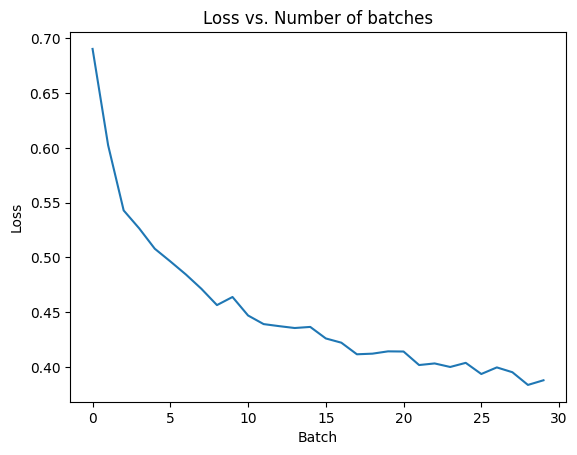

In [214]:
#Loss vs. Number of batches
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss vs. Number of batches')
plt.show()


## Save trained model weigths

In [215]:
#save model weights
torch.save(model.state_dict(), 'model_weights.pth')

## Load model weights

In [216]:
#load model weights and bias
torch.manual_seed(1)
modelo_cargado = Net(in_channels=1, out_channels=3, kernel_size=3)  
modelo_cargado.load_state_dict(torch.load('model_weights.pth'))
modelo_cargado.to(device)
modelo_cargado.eval()   

Net(
  (conv1): MyConvolution()
  (conv2): MyConvolution()
  (fc1): Linear(in_features=225, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [217]:
accuracy,precision,recall=testing(modelo_cargado.eval(),test_loader)

Accuracy: 0.827
Precision: 0.829
Recall: 0.827


## Testing Metrics

In [218]:
accuracy,precision,recall=testing(model.eval(),test_loader)

Accuracy: 0.827
Precision: 0.829
Recall: 0.827
